# Transfer Learning with Differential Privacy 
In this code, transfer learning is used to classify whether a bean leaf is healthy or diseased. Models are tested with and without differential privacy. 

In [277]:
# References 
# https://blog.openmined.org/differentially-private-deep-learning-using-opacus-in-20-lines-of-code/
#https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

#conda activate privfarm


In [276]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    
    
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]), 
    
}

data_dir = 'bean_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val','test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val','test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val','test']}
class_names = image_datasets['train'].classes



device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


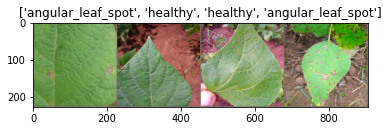

In [203]:
# Visualize images from dataloader

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [204]:
# Train Model Function

def train_model(model, criterion, optimizer, scheduler, num_epochs=25, delta=0,privacy=False):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                
            # Privacy *******************************************************************************
            
            if privacy == True: 
    
                epsilon, best_alpha = optimizer.privacy_engine.get_privacy_spent(delta) 
    
                print("epsilon", epsilon)
                print("best_alpha", best_alpha)
    
    
  
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)

    return model

In [205]:
# Returns accuracy metric. Test datasest is default, but can pass in validation and train

def check_accuracy(loader, model, dataset='test'):
    num_correct = 0
    num_samples = 0
    model.cuda()
    model.eval()
    
    with torch.no_grad():
        for x, y in loader[dataset]:
            x = x.cuda()
            y = y.cuda()
            scores = model(x)
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)
        
        print(f'Got {num_correct} / {num_samples} with accuracy {float(num_correct)/float(num_samples)*100:.2f}') 
    
    model.train()
    
    acc = (num_correct  / num_samples).cpu()
  
    return acc 

In [206]:
# Visualize predictions 


def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

Finetuning the convnet
----------------------

Load a pretrained model and reset final fully connected layer.




In [207]:
import torch
from opacus import PrivacyEngine

#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#model = model.to(device)


model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs,3)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

#Testing privacy engine /// Adding DP ********************************************PRIVACY

#privacy_engine = PrivacyEngine(model_ft.fc, batch_size=64, sample_size=60000, alphas=range(2,32), 
                              #noise_multiplier=1.3, max_grad_norm=1.0,)

#privacy_engine.attach(optimizer_ft)

######### Stop Privacy engine ******************************************************************

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [229]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=10, delta=1e-5)

Epoch 0/9
----------
train Loss: 0.2818 Acc: 0.9033
val Loss: 0.0501 Acc: 0.9850
Epoch 1/9
----------
train Loss: 0.3201 Acc: 0.8956
val Loss: 0.0753 Acc: 0.9699
Epoch 2/9
----------
train Loss: 0.2615 Acc: 0.9062
val Loss: 0.0681 Acc: 0.9624
Epoch 3/9
----------
train Loss: 0.2725 Acc: 0.9168
val Loss: 0.0734 Acc: 0.9699
Epoch 4/9
----------
train Loss: 0.2445 Acc: 0.9101
val Loss: 0.0510 Acc: 0.9850
Epoch 5/9
----------
train Loss: 0.2157 Acc: 0.9265
val Loss: 0.0593 Acc: 0.9850
Epoch 6/9
----------
train Loss: 0.1959 Acc: 0.9342
val Loss: 0.0599 Acc: 0.9774
Epoch 7/9
----------
train Loss: 0.2186 Acc: 0.9313
val Loss: 0.0617 Acc: 0.9699
Epoch 8/9
----------
train Loss: 0.2182 Acc: 0.9333
val Loss: 0.0561 Acc: 0.9774
Epoch 9/9
----------
train Loss: 0.1945 Acc: 0.9449
val Loss: 0.0581 Acc: 0.9774
Training complete in 1m 28s
Best val Acc: 0.984962


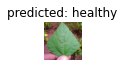

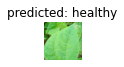

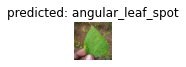

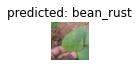

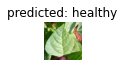

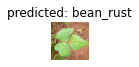

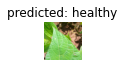

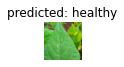

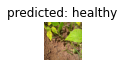

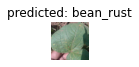

In [209]:
#Visualize model predictions . Input model and number of images

visualize_model(model_ft,10)

In [234]:
NonDPFineTune = check_accuracy(dataloaders,model_ft )

Got 123 / 128 with accuracy 96.09


## Feature Extraction of the ConvNet
The entire network is frozen is except for the last layer. Backward propogation is turned off by setting requires_grad == False. 

In [235]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 3) ###Very import = number of classes (beans = 3)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [236]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=5)

Epoch 0/4
----------
train Loss: 0.9644 Acc: 0.5774
val Loss: 0.3948 Acc: 0.8496
Epoch 1/4
----------
train Loss: 0.7558 Acc: 0.7012
val Loss: 0.5119 Acc: 0.8045
Epoch 2/4
----------
train Loss: 0.6795 Acc: 0.7137
val Loss: 0.3253 Acc: 0.8872
Epoch 3/4
----------
train Loss: 0.6480 Acc: 0.7099
val Loss: 0.2588 Acc: 0.9023
Epoch 4/4
----------
train Loss: 0.6888 Acc: 0.7166
val Loss: 0.2564 Acc: 0.9098
Training complete in 0m 26s
Best val Acc: 0.909774


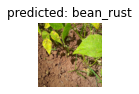

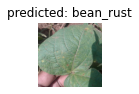

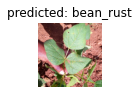

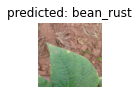

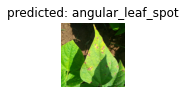

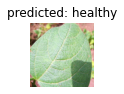

In [79]:
#Visualize model predictions . Input model and number of images

visualize_model(model_conv)


In [240]:
NonDPFeatureExtractor = check_accuracy(dataloaders,model_conv)

Got 108 / 128 with accuracy 84.38


# Transfer Learning with Privacy 

Part 1: Finetuning the Convent using the privacy engine provided by Opacus. 

In [238]:
###Part I. Finetuning the Convnet with Privacy 


import torch
from opacus import PrivacyEngine

#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#model = model.to(device)


model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs,3)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

#Testing privacy engine /// Adding DP ********************************************PRIVACY

privacy_engine = PrivacyEngine(model_ft.fc, batch_size=64, sample_size=60000, alphas=range(2,32), 
                              noise_multiplier=1.3, max_grad_norm=1.0,)

privacy_engine.attach(optimizer_ft)

######### Stop Privacy engine ******************************************************************

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

C:\Users\mikeb\anaconda3\envs\privFarm\lib\site-packages\opacus\privacy_engine.py:638: UserWarning: The sample rate will be defined from ``batch_size`` and ``sample_size``.The returned privacy budget will be incorrect.
  warnings.warn(
C:\Users\mikeb\anaconda3\envs\privFarm\lib\site-packages\opacus\privacy_engine.py:229: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_rng`` turned on.
  warnings.warn(


In [239]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=5, delta=1e-5, privacy=True)

Epoch 0/4
----------


C:\Users\mikeb\anaconda3\envs\privFarm\lib\site-packages\torch\nn\modules\module.py:974: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


train Loss: 0.7713 Acc: 0.6702
epsilon 0.3447923141374444
best_alpha 23.0
val Loss: 0.4004 Acc: 0.8722
epsilon 0.3447923141374444
best_alpha 23.0
Epoch 1/4
----------
train Loss: 0.5792 Acc: 0.8008
epsilon 0.3532440613438554
best_alpha 23.0
val Loss: 0.2129 Acc: 0.9098
epsilon 0.3532440613438554
best_alpha 23.0
Epoch 2/4
----------
train Loss: 0.6403 Acc: 0.7940
epsilon 0.3616958085502664
best_alpha 23.0
val Loss: 0.1482 Acc: 0.9323
epsilon 0.3616958085502664
best_alpha 23.0
Epoch 3/4
----------
train Loss: 0.6971 Acc: 0.7669
epsilon 0.3652748331275726
best_alpha 22.0
val Loss: 0.1869 Acc: 0.9323
epsilon 0.3652748331275726
best_alpha 22.0
Epoch 4/4
----------
train Loss: 0.5969 Acc: 0.8037
epsilon 0.36796303327519
best_alpha 22.0
val Loss: 0.4644 Acc: 0.8421
epsilon 0.36796303327519
best_alpha 22.0
Training complete in 0m 44s
Best val Acc: 0.932331


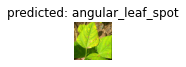

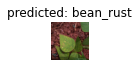

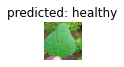

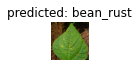

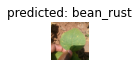

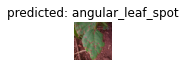

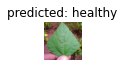

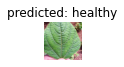

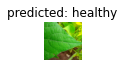

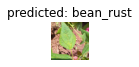

In [241]:
#Visualize model predictions . Input model and number of images

visualize_model(model_ft,10)

In [242]:
DPFineTune = check_accuracy(dataloaders,model_ft )

Got 113 / 128 with accuracy 88.28


# Feature Extraction with Differential Privacy 
Part II. Feature extraction with the privacy engine provided by Opacus. 

In [243]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 3) ###Very import = number of classes (beans = 3)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)


#Testing privacy engine /// Adding DP ********************************************PRIVACY

##### Review to see if right model - model-conv or model_conv.fc????? Check above as well (finetuning model)

privacy_engine = PrivacyEngine(model_conv.fc, batch_size=64, sample_size=60000, alphas=range(2,32), 
                              noise_multiplier=1.3, max_grad_norm=1.0,)

privacy_engine.attach(optimizer_conv)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

C:\Users\mikeb\anaconda3\envs\privFarm\lib\site-packages\opacus\privacy_engine.py:638: UserWarning: The sample rate will be defined from ``batch_size`` and ``sample_size``.The returned privacy budget will be incorrect.
  warnings.warn(
C:\Users\mikeb\anaconda3\envs\privFarm\lib\site-packages\opacus\privacy_engine.py:229: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_rng`` turned on.
  warnings.warn(


In [244]:
# Feature extraction with privacy , set epochs and delta

model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler,delta=1e-5, num_epochs=5,privacy=True)

Epoch 0/4
----------


C:\Users\mikeb\anaconda3\envs\privFarm\lib\site-packages\torch\nn\modules\module.py:974: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


train Loss: 1.2024 Acc: 0.3849
epsilon 0.3447923141374444
best_alpha 23.0
val Loss: 1.1148 Acc: 0.5113
epsilon 0.3447923141374444
best_alpha 23.0
Epoch 1/4
----------
train Loss: 1.1241 Acc: 0.4516
epsilon 0.3532440613438554
best_alpha 23.0
val Loss: 0.9402 Acc: 0.5940
epsilon 0.3532440613438554
best_alpha 23.0
Epoch 2/4
----------
train Loss: 1.1601 Acc: 0.4990
epsilon 0.3616958085502664
best_alpha 23.0
val Loss: 1.1084 Acc: 0.4737
epsilon 0.3616958085502664
best_alpha 23.0
Epoch 3/4
----------
train Loss: 1.2115 Acc: 0.4826
epsilon 0.3652748331275726
best_alpha 22.0
val Loss: 1.2006 Acc: 0.5038
epsilon 0.3652748331275726
best_alpha 22.0
Epoch 4/4
----------
train Loss: 1.1779 Acc: 0.5338
epsilon 0.36796303327519
best_alpha 22.0
val Loss: 1.0481 Acc: 0.5789
epsilon 0.36796303327519
best_alpha 22.0
Training complete in 0m 26s
Best val Acc: 0.593985


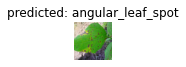

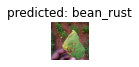

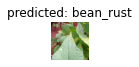

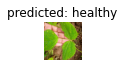

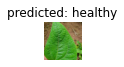

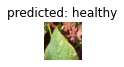

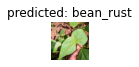

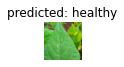

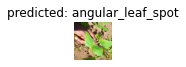

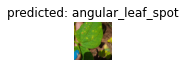

In [245]:
visualize_model(model_conv,10)

In [246]:
DPFeatureExtractor = check_accuracy(dataloaders,model_conv )


Got 77 / 128 with accuracy 60.16


In [269]:
Test_Acc = [NonDPFineTune, DPFineTune,NonDPFeatureExtractor, DPFeatureExtractor]
x = ["NonDPFineTune", "DPFineTune","NonDPFeatureExtractor", "DPFeatureExtractor"]



## Final Results of all four models 

Model 1: NonDPFineTune - Fine tuning of ConvNet without differential privacy. 
Model 2: DPFineTune - Fine tuning of ConvNet with differential privacy. 
Model 3: NonDPFeatureExtractor - Feature extraction of ConvNet without differential privacy. 
Model 4: DPFeatureExtractor - Feature extraction of ConvNet with differential privacy. 

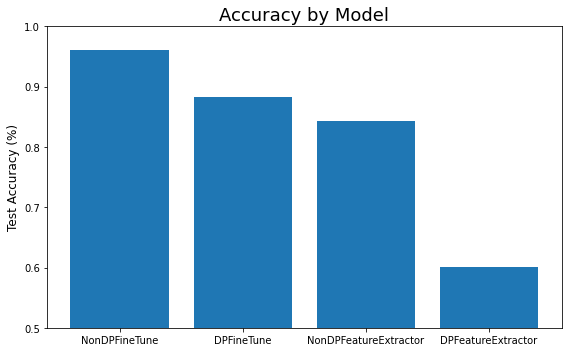

<Figure size 432x288 with 0 Axes>

In [271]:
x_pos = [i for i, _ in enumerate(x)]

#plt.tight_layout()
fig = plt.figure(figsize=(8,5))
plt.bar(x_pos,Test_Acc)

#plt.xlabel(x)
plt.ylim(.50,1)
plt.ylabel('Test Accuracy (%)', fontsize = 12)
plt.title('Accuracy by Model', fontsize = 18)
plt.xticks(x_pos,x,fontsize=10)
plt.tight_layout()



plt.show()
plt.savefig('DPModel_Accuracy.jpg')

# Summary  
As expected, there is a drop in accuracy when differential privacy is applied. However, finetuning the ConvNet with differential privacy applied still performed better than the feature extractor without differential privacy. 